#Using deep features to build an image classifier

#Fire up GraphLab Create

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sklearn, pandas
import numpy as np

#Load a common image analysis dataset

We will use a popular benchmark dataset in computer vision called CIFAR-10.  

(We've reduced the data to just 4 categories = {'cat','bird','automobile','dog'}.)

This dataset is already split into a training set and test set.  

In [4]:
image_train = pandas.read_csv('/content/drive/MyDrive/FUNIX Labs/Lab 14/image_train_data.csv')
image_test = pandas.read_csv('/content/drive/MyDrive/FUNIX Labs/Lab 14/image_test_data.csv')

#Exploring the image data

In [5]:
#graphlab.canvas.set_target('ipynb')
import matplotlib.pyplot as plt
%matplotlib inline
def show_image(image_data, dimension=(32, 32, 3)):
    image = np.reshape(image_data, dimension)
    plt.axis('off')
    plt.imshow(image)       
    
def show_images(images, cols=3):
    rows = len(images) // cols + ( 0 if len(images) % cols == 0 else 1)
    fig = plt.figure(figsize=(cols, rows))
    for i, img_data in enumerate(images):
        #i_row, i_col = i % cols, i // cols
        fig.add_subplot(rows, cols, i+1)
        show_image(img_data)

In [6]:
#[it for it in image_train['image_array'][:10].values]
import itertools, io
def convert_img(img): 
    stringbuf = io.StringIO(img[1:-1])
    array = np.loadtxt(stringbuf, dtype=np.uint8)
    stringbuf.close()
    #print(np.shape(array))
    return array
def variable_length_to_2d(series):
    return np.array(list(itertools.zip_longest(*series.values, fillvalue=0))).T
image_train['image_np'] = image_train['image_array'].map(convert_img)
image_test['image_np'] = image_test['image_array'].map(convert_img)
#image_train['image_np'] = image_np.tolist()
print(np.shape(image_train['image_np'][0]), np.shape(image_test['image_np'][0]))

(3072,) (3072,)


#Train a classifier on the raw image pixels

We first start by training a classifier on just the raw pixels of the image.

bird


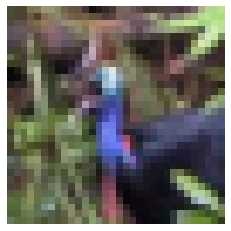

In [7]:
show_image(image_train['image_np'].values[0])
print(image_train['label'][0])

In [8]:
#raw_pixel_model = graphlab.logistic_classifier.create(image_train,target='label',
#                                              features=['image_array'])
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

raw_pixel_model = LogisticRegression()
label_encoder = LabelEncoder()

train_labels = label_encoder.fit_transform(image_train['label'])
train_data = variable_length_to_2d(image_train['image_np'])
print(np.shape(train_data), np.shape(train_labels))
raw_pixel_model.fit(train_data, train_labels)

(2005, 3072) (2005,)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#Make a prediction with the simple model based on raw pixels

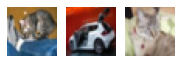

In [9]:
show_images(image_test[0:3]['image_np'].values)

In [10]:
image_test[0:3]['label']

0           cat
1    automobile
2           cat
Name: label, dtype: object

In [11]:
test_data = variable_length_to_2d(image_test['image_np'])
# force the test_data to the features size of train_data
#features_size = np.shape(train_data)[1]
#test_size = np.shape(test_data)[1]
#test_data = np.pad(test_data, ((0, 0), (0, features_size-test_size)), mode='constant', constant_values=0)[:, :features_size]
test_preds = raw_pixel_model.predict(test_data[0:3])
label_encoder.inverse_transform(test_preds)

array(['bird', 'dog', 'dog'], dtype=object)

The model makes wrong predictions for all three images.

#Evaluating raw pixel model on test data

In [12]:
#raw_pixel_model.evaluate(image_test)
from sklearn.metrics import confusion_matrix, precision_score
test_preds = raw_pixel_model.predict(test_data)
test_labels = label_encoder.transform(image_test['label'])
print(label_encoder.classes_)
print(confusion_matrix(test_labels, test_preds))
print(precision_score(test_labels, test_preds, average="micro"))

['automobile' 'bird' 'cat' 'dog']
[[629 131 103 137]
 [104 492 180 224]
 [127 216 341 316]
 [ 86 255 263 396]]
0.4645


The accuracy of this model is poor, getting only about 46% accuracy.

#Can we improve the model using deep features

We only have 2005 data points, so it is not possible to train a deep neural network effectively with so little data.  Instead, we will use transfer learning: using deep features trained on the full ImageNet dataset, we will train a simple model on this small dataset.

In [13]:
len(image_train)

2005

##Computing deep features for our images

The two lines below allow us to compute deep features.  This computation takes a little while, so we have already computed them and saved the results as a column in the data you loaded. 

(Note that if you would like to compute such deep features and have a GPU on your machine, you should use the GPU enabled GraphLab Create, which will be significantly faster for this task.)

In [14]:
#deep_learning_model = graphlab.load_model('http://s3.amazonaws.com/GraphLab-Datasets/deeplearning/imagenet_model_iter45')
#image_train['deep_features'] = deep_learning_model.extract_features(image_train)

As we can see, the column deep_features already contains the pre-computed deep features for this data. 

In [15]:
image_train.head()

,id,image,label,deep_features,image_array,image_np
0,24,Height: 32 Width: 32,bird,[0.242872 1.09545 0 0.39363 0 0 11.8949 0 0 0 ...,[73 77 58 71 68 50 77 69 44 120 116 83 125 120...,"[73, 77, 58, 71, 68, 50, 77, 69, 44, 120, 116,..."
1,33,Height: 32 Width: 32,cat,[0.525088 0 0 0 0 0 9.94829 0 0 0 0 0 1.01264 ...,[7 5 8 7 5 8 5 4 6 7 4 7 11 5 9 11 5 9 17 11 1...,"[7, 5, 8, 7, 5, 8, 5, 4, 6, 7, 4, 7, 11, 5, 9,..."
2,36,Height: 32 Width: 32,cat,[0.566016 0 0 0 0 0 9.9972 0 0 0 1.38345 0 0.7...,[169 122 65 131 108 75 193 196 192 218 221 222...,"[169, 122, 65, 131, 108, 75, 193, 196, 192, 21..."
3,70,Height: 32 Width: 32,dog,[1.1298 0 0 0.778194 0 0.758051 9.83053 0 0 0....,[154 179 152 159 183 157 165 189 162 174 199 1...,"[154, 179, 152, 159, 183, 157, 165, 189, 162, ..."
4,90,Height: 32 Width: 32,bird,[1.71787 0 0 0 0 0 9.33936 0 0 0 0 0 0.412137 ...,[216 195 180 201 178 160 210 184 164 212 188 1...,"[216, 195, 180, 201, 178, 160, 210, 184, 164, ..."


#Given the deep features, let's train a classifier

In [16]:
image_train['deep_features'].values[0]

'[0.242872 1.09545 0 0.39363 0 0 11.8949 0 0 0 0 0 0 0 0 0 0 0.57885 0.495467 2.51413 0 1.51801 0 0 0 0 0 0 0 0 0 0 0 0 0 1.5814 0 0 2.59561 2.70796 0 0 0 0.85099 0 0.720349 0 0 0 0 0 0.270036 0 0 0 0 0.085928 0 0.701023 0 0 0 0 0.0248057 0 0 0.17549 0 0 0 0 0 2.39278 0 0 4.47187 0 1.63583 0 4.41748 0 0 0 0 0 0 0 0 0 0 0 1.41179 0 0 0 0 0 0 0 0 0 0 0.124768 0 0 0.895716 0 0 0.333499 0 0 0.207873 2.54354 0 0 0.184338 0 1.42003 0 0 0 0 0 0 0 0 0 0 0 1.43542 0 0 0 0 0 1.93689 0 0 0 0 0 0.885218 0 0 1.42506 0 0 1.30532 1.31116 0 0 0 0 0 0 2.8661 0 0 0 0 0 0.841856 0 0 0 0 2.39469 0 0 0 2.17862 0 1.20806 0 1.02115 0 0 0 0 1.0027 1.00278 2.88097 0 0 0 0 0 0 0.0444847 11.2869 0 0 0 0 0 0 0 0 0 0 0 0 0 1.25519 0 1.01393 1.10103 0 2.65495 0.0743851 3.38323 0 0 1.33688 0.480166 0.935999 0.130775 0 0 0 2.55289 0 0 1.98796 0 1.81481 0 0.688944 0 0.318657 2.12182 0 0.5624 1.13918 1.94655 3.15611 0 0 1.68452 0 1.21483 1.07752 0.345013 1.23942 0 0 0 0 0 0 0 0 0 0.77367 0 2.06167 0 0 0 0 2.8326 2.5339

In [17]:
def convert_features(img):
    stringbuf = io.StringIO(img[1:-1])
    array = np.loadtxt(stringbuf, dtype=np.float16)
    stringbuf.close()
    return array
image_train['deep_np'] = image_train['deep_features'].map(convert_features)
image_test['deep_np'] = image_test['deep_features'].map(convert_features)
deep_features_model = LogisticRegression()

train_data = variable_length_to_2d(image_train['deep_np'])
print(np.shape(train_data), np.shape(train_labels))
deep_features_model.fit(train_data, train_labels)
#deep_features_model = graphlab.logistic_classifier.create(image_train,
#                                                         features=['deep_features'],
#                                                         target='label')

(2005, 4096) (2005,)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#Apply the deep features model to first few images of test set

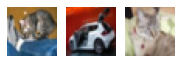

In [18]:
show_images(image_test[0:3]['image_np'].values)

In [19]:
test_data = variable_length_to_2d(image_test['deep_np'])
label_encoder.inverse_transform(deep_features_model.predict(test_data[0:3]))

array(['cat', 'automobile', 'cat'], dtype=object)

The classifier with deep features gets all of these images right!

#Compute test_data accuracy of deep_features_model

As we can see, deep features provide us with significantly better accuracy (about 78%)

In [20]:
test_preds = deep_features_model.predict(test_data)
test_labels = label_encoder.transform(image_test['label'])
print(label_encoder.classes_)
print(confusion_matrix(test_labels, test_preds))
print(precision_score(test_labels, test_preds, average="micro"))

['automobile' 'bird' 'cat' 'dog']
[[969  16   9   6]
 [  8 810 130  52]
 [ 16  79 684 221]
 [  3  59 215 723]]
0.7965
